<B>Importing libraries!<b>

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re
from math import log,e

sns.set(rc={'figure.figsize': (11.7, 8.27)})

font = {'fontname': 'monospace', 'color':  'royalblue', 'weight': 'bold', 'size': 18}
title_font = {'fontname': 'monospace', 'color':  'slategrey', 'weight': 'bold', 'size': 24}

<b>Preparing data<b>

In [136]:
df_fields = pd.read_csv('fields.csv',sep=';',encoding ='cp1251')
df_fields.columns = df_fields.iloc[0,:]
df_fields = df_fields.iloc[2:,:-1]
df_fields.index -= 2
for column in ['area','yield_plan','k2o','p2o5','humus','ph']:
  df_fields[column] = df_fields[column].str.replace(',','.').astype('float64')
df_fields['season'] = df_fields['season'].astype('int')
df_fields['season'] = df_fields['season'].astype('str')

#Добавляем логарифмы химических показателей
df_fields['k2o_log'] = df_fields['k2o'].apply(lambda x: np.nan if x <= 0 else x).apply(log)
df_fields['p2o5_log'] = df_fields['p2o5'].apply(lambda x: np.nan if x <= 0 else x).apply(log)
df_fields['humus_log'] = df_fields['humus'].apply(lambda x: np.nan if x <= 0 else x).apply(log)


df_works = pd.read_csv('works.csv',sep=';',encoding='cp1251')
df_works.columns = df_works.iloc[1,:]
df_works = df_works.iloc[2:,:]
df_works.index -= 2
for column in ['area','proc_depth','prod_dry_perc','prod_weight','prod_humid',\
               'prod_impur','yield_fact']:
    df_works[column] = df_works[column].str.replace(',','.').astype('float64')
df_works['yield_fact'] = pd.Series(df_works['prod_weight'][i]/df_works['area'][i] if df_works['prod_weight'][i] > 0 else np.nan for i in range(len(df_works)))
for i in df_works['yield_fact'].index:
    if df_works.loc[i,'yield_fact'] > 500:
        df_works.loc[i,'yield_fact'] = df_works.loc[i,'yield_fact']/1000
df_works = df_works[(df_works['yield_fact']<100)|(df_works['yield_fact'].isna())].drop_duplicates(subset=['work_id'])
df_works.index = pd.Series(range(len(df_works)))
df_works['start_date'] = pd.to_datetime(df_works['start_date'], format='%d.%m.%Y')
df_works['season'] = df_works['season'].astype('int')
df_works['season'] = df_works['season'].astype('str')

df_value = pd.read_csv('value.csv',sep=';',encoding='cp1251')
df_value.columns = df_value.iloc[1,:]
df_value = df_value.iloc[2:,:]
df_value.index -= 2
for column in ['inv_item_weight','inv_item_dose']:
    df_value[column] = df_value[column].str.replace(',','.').astype('float64')

#добавляем столбик с культурами в works
cultures = df_fields.pivot(index = 'field',columns = 'season',values = 'crop')
df_works['crop'] = pd.Series(cultures.loc[df_works.loc[i,'field'],\
  df_works.loc[i,'season']] if df_works['field'][i] in cultures.index else np.nan for i in df_works.index)

C:\Users\mp155\AppData\Local\Temp\ipykernel_608\1730626979.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_works = pd.read_csv('works.csv',sep=';',encoding='cp1251')


In [137]:
df_fields = pd.read_csv("fields_cleared_yield.csv")
df_works = pd.read_csv("works_cleared_yield.csv")

In [138]:
df_value = df_value[df_value["inv_item_type"]=="Удобрения"]

In [142]:
df_value #checking data structure

1,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.60,кг,260.00,28.10.2024,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.00,м3,65.00,28.10.2024,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.00,т,65.00,28.10.2024,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.00,т,65.00,28.10.2024,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.00,т,65.00,28.10.2024,D5D1EADB-D159-4CF8-8C2A-171517ACD403
...,...,...,...,...,...,...,...,...
170808,47.22.06.019.00,Удобрения,Удобрение 31,5324.80,т,332.80,03.01.2022,0B9A32C5-7DE5-4500-9CCF-397E3BEF7FE9
170809,47.22.06.019.00,Удобрения,Удобрение 31,319.49,т,124.80,03.01.2022,B7124DCE-3380-4DD0-B404-61ECC1D9EC52
170810,47.22.06.019.00,Удобрения,Удобрение 31,131.04,т,91.00,03.01.2022,1050500D-98E5-4122-BAB8-60B471E6BFD8
170811,72.22.02.055.00,Удобрения,Удобрение 49,13773.53,т,57.33,01.01.2022,2E6EB7CA-964C-4EA7-A01A-8386A73AAF40


In [174]:
df = df_value
#Group by 'field' and 'inv_item_name' and sum 'inv_item_dose'
grouped = df.groupby(['field', 'inv_item_name'], as_index=False)['inv_item_dose'].sum()
#Pivot the dataframe
pivot_df = grouped.pivot(index='field', columns='inv_item_name', values='inv_item_dose')
#Reset the index to remove the double indexing
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.fillna(0)  

inv_item_name            field  Удобрение 1  Удобрение 10  Удобрение 11  \
0              02.09.02.002.01          0.0           0.0           0.0   
1              02.09.02.003.00          0.0           0.0           0.0   
2              02.09.02.013.00          0.0           0.0           0.0   
3              02.09.02.015.00          0.0           0.0           0.0   
4              02.09.02.019.00          0.0           0.0           0.0   
...                        ...          ...           ...           ...   
5979           72.22.10.043.00          0.0           0.0           0.0   
5980           72.22.10.044.00          0.0           0.0           0.0   
5981           72.22.10.046.00          0.0           0.0           0.0   
5982           72.22.10.047.00          0.0           0.0           0.0   
5983           72.22.10.048.00          0.0           0.0           0.0   

inv_item_name  Удобрение 12  Удобрение 13  Удобрение 14  Удобрение 15  \
0                       0.

In [182]:
pivot_df = pivot_df.drop(columns=['inv_item_name'], errors='ignore')

In [184]:
pivot_df

inv_item_name,field,Удобрение 1,Удобрение 10,Удобрение 11,Удобрение 12,Удобрение 13,Удобрение 14,Удобрение 15,Удобрение 16,Удобрение 17,...,Удобрение 68,Удобрение 7,Удобрение 70,Удобрение 71,Удобрение 72,Удобрение 73,Удобрение 74,Удобрение 75,Удобрение 8,Удобрение 9
0,02.09.02.002.01,0.0,0.0,0.0,0.0,0.0,0.0,0.16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,02.09.02.003.00,0.0,0.0,0.0,130.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02.09.02.013.00,0.0,0.0,0.0,130.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,02.09.02.015.00,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,02.09.02.019.00,0.0,0.0,0.0,130.0,0.0,0.0,0.08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,72.22.10.043.00,0.0,0.0,0.0,0.0,0.0,0.0,10.93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5980,72.22.10.044.00,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5981,72.22.10.046.00,0.0,0.0,0.0,0.0,0.0,0.0,1.27,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5982,72.22.10.047.00,0.0,0.0,0.0,0.0,0.0,0.0,1.59,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Cluzterization!<b>
/
chaotic attempts to cluster the data /

In [186]:
df = pivot_df
X = df
X_data = X.drop("field", axis=1)  # Drop the 'field' column

# Standardize the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Apply KMeans clustering
n_clusters = 2  # Choose the number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the cleaned DataFrame (X)
X['cluster'] = cluster_labels

# Now merge back the cluster labels into the original df_diff (which may have missing values)
df = df.merge(X[['field', 'cluster']], on=[['field']], how='left')

# Reduce the data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Optionally, you can check the cluster centers in the original feature space:
print("Cluster Centers (in the original scaled space):")
print(kmeans.cluster_centers_)


KeyError: ['field']

In [172]:
df

inv_item_name,Удобрение 1,Удобрение 10,Удобрение 11,Удобрение 12,Удобрение 13,Удобрение 14,Удобрение 15,Удобрение 16,Удобрение 17,Удобрение 18,...,Удобрение 68,Удобрение 7,Удобрение 70,Удобрение 71,Удобрение 72,Удобрение 73,Удобрение 74,Удобрение 75,Удобрение 8,Удобрение 9
field,,,,,,,,,,,,,,,,,,,,,
02.09.02.002.01,0.0,0.0,0.0,0.0,0.0,0.0,0.16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02.09.02.003.00,0.0,0.0,0.0,130.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02.09.02.013.00,0.0,0.0,0.0,130.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02.09.02.015.00,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02.09.02.019.00,0.0,0.0,0.0,130.0,0.0,0.0,0.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72.22.10.043.00,0.0,0.0,0.0,0.0,0.0,0.0,10.93,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72.22.10.044.00,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72.22.10.046.00,0.0,0.0,0.0,0.0,0.0,0.0,1.27,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


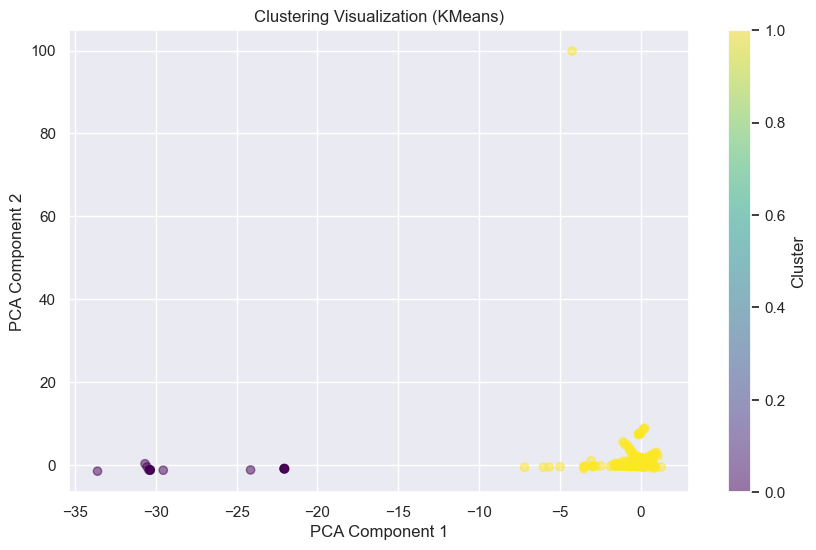

In [188]:
X = df
X_data = X.drop(['field'], axis=1)  # Drop the 'field' column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [206]:
pivot_df_0 = pivot_df[pivot_df["cluster"]==0]

In [208]:
pivot_df_0

inv_item_name,field,Удобрение 1,Удобрение 10,Удобрение 11,Удобрение 12,Удобрение 13,Удобрение 14,Удобрение 15,Удобрение 16,Удобрение 17,...,Удобрение 7,Удобрение 70,Удобрение 71,Удобрение 72,Удобрение 73,Удобрение 74,Удобрение 75,Удобрение 8,Удобрение 9,cluster
846,36.02.02.001.00,0.0,455.0,0.0,0.00,0.0,0.0,299.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
848,36.02.02.002.01,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
851,36.02.02.006.01,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
852,36.02.02.007.00,0.0,65.0,0.0,0.00,0.0,0.0,299.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
883,36.02.02.029.04,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
911,36.02.02.058.00,0.0,260.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
923,36.02.02.068.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
926,36.02.02.069.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,156.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1606,36.13.12.001.00,0.0,65.0,0.0,0.00,0.0,0.0,299.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1609,36.13.12.004.00,0.0,65.0,0.0,0.00,0.0,0.0,299.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<Axes: xlabel='inv_item_name', ylabel='inv_item_dose'>

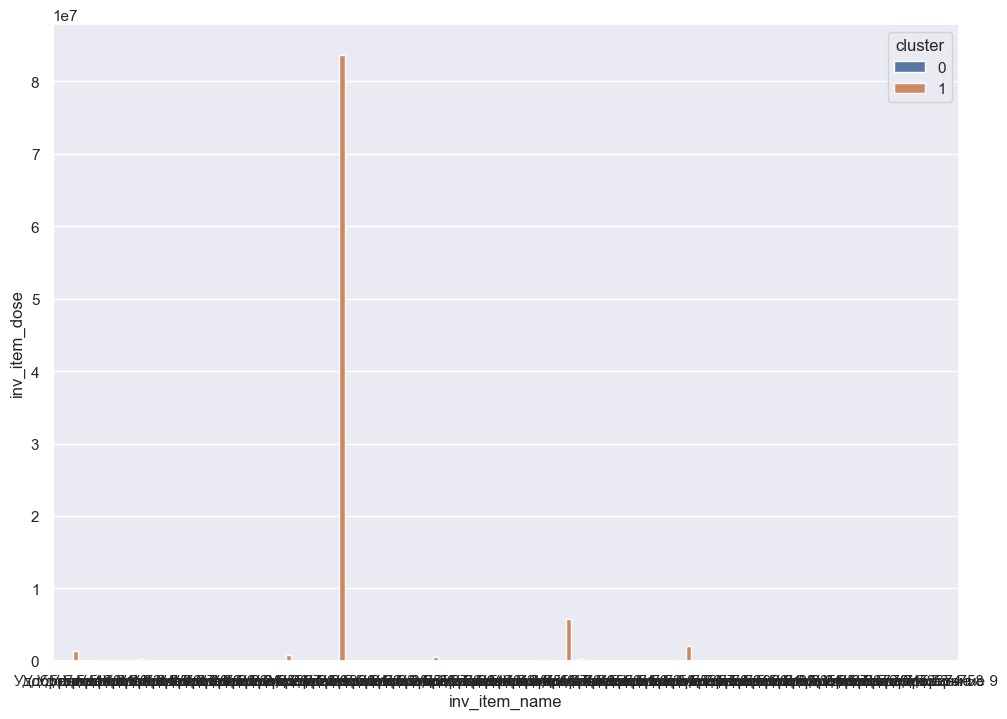

In [202]:
df_melted = pivot_df.melt(id_vars=["field", "cluster"], var_name="inv_item_name", value_name="inv_item_dose")

# Step 2: Group by the fertilizer (inv_item_name) and cluster to sum doses
grouped = df_melted.groupby(['inv_item_name', 'cluster'], as_index=False)['inv_item_dose'].sum()

# Step 3: Create the bar plot using Seaborn

sns.barplot(data=grouped, x='inv_item_name', y='inv_item_dose', hue='cluster')

In [200]:
grouped = df.groupby(['inv_item_name', 'cluster'], as_index=False)['inv_item_dose'].sum()

KeyError: 'inv_item_name'

In [198]:
pivot_df.groupby("cluster").describe()

inv_item_name Удобрение 1                                                  \
                    count      mean        std  min  25%  50%  75%    max   
cluster                                                                     
0                    15.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0   
1                  5969.0  1.916569  28.437724  0.0  0.0  0.0  0.0  975.0   

inv_item_name Удобрение 10              ... Удобрение 8        Удобрение 9  \
                     count        mean  ...         75%    max       count   
cluster                                 ...                                  
0                     15.0   65.000000  ...         0.0    0.0        15.0   
1                   5969.0  239.150871  ...         0.0  390.0      5969.0   

inv_item_name                                                  
                   mean        std  min  25%  50%  75%    max  
cluster                                                        
0              0.000000   0.000000  0.0  0.0  0.0  0.0    0.0  
1              2.548166  25.295957  0.0  0.0  0.0  0.0  780.0  

[2 rows x 544 columns]

In [ ]:
sns.barplot(data=pivot_df, x='inv_item_name', y='inv_item_dose', hue='cluster')


In [192]:
pivot_clusters = pd.DataFrame({
    "field" : pivot_df["field"],
    "cluster": pivot_df["cluster"]
})

In [194]:
pivot_clusters

,field,cluster
0,02.09.02.002.01,1
1,02.09.02.003.00,1
2,02.09.02.013.00,1
3,02.09.02.015.00,1
4,02.09.02.019.00,1
...,...,...
5979,72.22.10.043.00,1
5980,72.22.10.044.00,1
5981,72.22.10.046.00,1
5982,72.22.10.047.00,1


In [196]:
fields_24

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,p2o5,k2o,humus,ph,k2o_log,p2o5_log,humus_log,yield_fact,delta,z
6552,22.47.01.001.01,Алтай,пашня,NaN,2024,Пар,Оз.пшеница мягкая,NaN,306.22,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6553,22.47.01.001.02,Алтай,пашня,NaN,2024,Пар,Пар,NaN,63.16,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6554,22.47.01.002.00,Алтай,пашня,4.0,2024,Оз.пшеница мягкая,Пар,NaN,485.79,Скипетр,...,5.72,219.78,534.37,3.85,5.392627,1.743969,6.281088,1.366600,-2.633400,-0.855668
6555,22.47.01.003.00,Алтай,пашня,4.0,2024,Пар,Оз.пшеница мягкая,NaN,452.25,NaN,...,5.94,205.15,497.48,6.49,5.323741,1.781709,6.209555,NaN,NaN,NaN
6556,22.47.01.004.00,Алтай,пашня,3.0,2024,Пар,Оз.пшеница мягкая,NaN,269.64,NaN,...,5.94,183.26,296.60,6.16,5.210906,1.781709,5.692384,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13190,36.29.07.041.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,93.99,Ликамеро,...,6.16,114.40,103.39,5.17,4.739701,1.818077,4.638508,1.311370,-3.688630,-1.157091
13191,36.29.07.042.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,70.48,Ликамеро,...,6.05,89.10,77.53,4.95,4.489759,1.800058,4.350665,1.943890,-3.056110,-0.693206
13192,36.29.07.043.00,Воронеж,пашня,4.0,2024,Соя,Соя,NaN,115.70,Султана,...,5.94,148.50,127.27,4.18,5.000585,1.781709,4.846311,1.267500,-0.832500,-0.054483
13193,36.29.07.044.00,Воронеж,пашня,3.0,2024,Соя,Соя,NaN,114.65,Султана,...,5.94,81.40,126.12,4.84,4.399375,1.781709,4.837234,0.570000,-1.530000,-1.120190


In [49]:
df_fields["delta"] = df_fields["yield_fact"] - df_fields["yield_plan"]

In [57]:
fields_23 = df_fields[df_fields["season"]==2023]
fields_24 = df_fields[df_fields["season"]==2024]

In [59]:
fields_23 = pd.DataFrame({
    "field": fields_23["field"],
    "delta" : fields_23["delta"],
    "crop" : fields_23["crop"],
    "crop_predecessor" : fields_23["crop_predecessor"],
    "season" : fields_23["season"],
    "p2o5" : fields_23["p2o5"],
    "k2o" : fields_23["k2o"],
    "humus" : fields_23["humus"],
    "ph" : fields_23["ph"],
    "yield_fact" : fields_23["yield_fact"]    
})

In [61]:
df=fields_23
df =df.dropna(subset="delta")


In [63]:
# Group by 'crop' and 'crop_predecessor' and calculate the mean of the numerical features
grouped = df.groupby(['crop', 'crop_predecessor']).agg(
    {'delta': 'mean',
     'p2o5': 'mean',
     'k2o': 'mean',
     'humus': 'mean',
     'ph': 'mean'
     
    }).reset_index()

# Count the occurrences of each combination of 'crop' and 'crop_predecessor'
count_group = df.groupby(['crop', 'crop_predecessor']).size().reset_index(name='count')

# Merge the mean values and the counts back into one dataframe
result = pd.merge(grouped, count_group, on=['crop', 'crop_predecessor'])

# Filter out rows with a count less than 30
result_filtered = result[result['count'] >= 10].drop(columns='count')

# The result_filtered dataframe is your final dataframe
print(result_filtered)

                       crop                          crop_predecessor  \
1                     Горох                         Оз.пшеница мягкая   
6                     Горох                         Яр.пшеница мягкая   
7                     Горох                                 Яр.ячмень   
18   Кл.кр.+тим.пр.лет корм                    Кл.кр.+тим.пр.лет корм   
20   Кл.кр.+тим.пр.лет корм  Яр.пшеница мягк.с подс.(кл.кр.+тим.корм)   
..                      ...                                       ...   
370               Яр.ячмень                              Подсолнечник   
371               Яр.ячмень                      Подсолнечник кондит.   
372               Яр.ячмень                                Сах.свекла   
376               Яр.ячмень                                       Соя   
378               Яр.ячмень                         Яр.пшеница мягкая   

        delta        p2o5         k2o     humus        ph  
1   -0.760718  127.370833  136.079167  5.060000  4.807500  
6  

In [69]:
df = result_filtered


In [71]:
df

,crop,crop_predecessor,delta,p2o5,k2o,humus,ph
1,Горох,Оз.пшеница мягкая,-0.760718,127.370833,136.079167,5.060000,4.807500
6,Горох,Яр.пшеница мягкая,-1.089385,107.973684,132.158421,6.093684,6.345263
7,Горох,Яр.ячмень,-1.053876,146.657500,131.890000,5.775000,6.039000
18,Кл.кр.+тим.пр.лет корм,Кл.кр.+тим.пр.лет корм,-2.342713,129.830333,105.668000,3.027333,5.370333
20,Кл.кр.+тим.пр.лет корм,Яр.пшеница мягк.с подс.(кл.кр.+тим.корм),-2.999717,59.910667,118.330000,4.792667,5.448000
...,...,...,...,...,...,...,...
370,Яр.ячмень,Подсолнечник,-1.638014,107.034808,134.550962,4.773462,4.538077
371,Яр.ячмень,Подсолнечник кондит.,-1.864866,112.150000,190.750000,5.435833,5.291667
372,Яр.ячмень,Сах.свекла,-2.219044,135.256000,187.704000,6.234800,6.886000
376,Яр.ячмень,Соя,-2.086485,107.503611,114.382500,4.875000,4.974722


In [79]:
df = df.drop("delta",axis=1)

In [81]:
X = df
X_data = X.drop(['crop', 'crop_predecessor'], axis=1)  # Drop the 'field' column

# Standardize the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Apply KMeans clustering
n_clusters = 2  # Choose the number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the cleaned DataFrame (X)
X['cluster'] = cluster_labels

# Now merge back the cluster labels into the original df_diff (which may have missing values)
df = df.merge(X[['crop', 'crop_predecessor', 'cluster']], on=[['crop', 'crop_predecessor']], how='left')

# Reduce the data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Optionally, you can check the cluster centers in the original feature space:
print("Cluster Centers (in the original scaled space):")
print(kmeans.cluster_centers_)


C:\Users\mp155\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KeyError: ['crop', 'crop_predecessor']

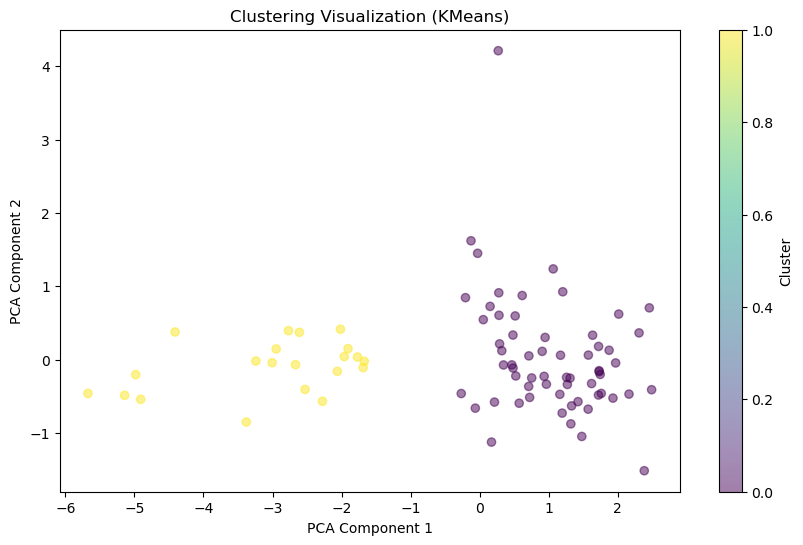

In [83]:
X = df
X_data = X.drop(['crop', 'crop_predecessor'], axis=1)  # Drop the 'field' column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [101]:
df

,crop,crop_predecessor,p2o5,k2o,humus,ph,cluster
1,Горох,Оз.пшеница мягкая,127.370833,136.079167,5.060000,4.807500,0
6,Горох,Яр.пшеница мягкая,107.973684,132.158421,6.093684,6.345263,0
7,Горох,Яр.ячмень,146.657500,131.890000,5.775000,6.039000,0
18,Кл.кр.+тим.пр.лет корм,Кл.кр.+тим.пр.лет корм,129.830333,105.668000,3.027333,5.370333,0
20,Кл.кр.+тим.пр.лет корм,Яр.пшеница мягк.с подс.(кл.кр.+тим.корм),59.910667,118.330000,4.792667,5.448000,0
...,...,...,...,...,...,...,...
370,Яр.ячмень,Подсолнечник,107.034808,134.550962,4.773462,4.538077,0
371,Яр.ячмень,Подсолнечник кондит.,112.150000,190.750000,5.435833,5.291667,0
372,Яр.ячмень,Сах.свекла,135.256000,187.704000,6.234800,6.886000,0
376,Яр.ячмень,Соя,107.503611,114.382500,4.875000,4.974722,0


In [109]:
fields_24 = fields_24.drop("Unnamed: 0",axis=1)

In [111]:
fields_24


,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,p2o5,k2o,humus,ph,k2o_log,p2o5_log,humus_log,yield_fact,delta,z
6552,22.47.01.001.01,Алтай,пашня,NaN,2024,Пар,Оз.пшеница мягкая,NaN,306.22,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6553,22.47.01.001.02,Алтай,пашня,NaN,2024,Пар,Пар,NaN,63.16,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6554,22.47.01.002.00,Алтай,пашня,4.0,2024,Оз.пшеница мягкая,Пар,NaN,485.79,Скипетр,...,5.72,219.78,534.37,3.85,5.392627,1.743969,6.281088,1.366600,-2.633400,-0.855668
6555,22.47.01.003.00,Алтай,пашня,4.0,2024,Пар,Оз.пшеница мягкая,NaN,452.25,NaN,...,5.94,205.15,497.48,6.49,5.323741,1.781709,6.209555,NaN,NaN,NaN
6556,22.47.01.004.00,Алтай,пашня,3.0,2024,Пар,Оз.пшеница мягкая,NaN,269.64,NaN,...,5.94,183.26,296.60,6.16,5.210906,1.781709,5.692384,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13190,36.29.07.041.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,93.99,Ликамеро,...,6.16,114.40,103.39,5.17,4.739701,1.818077,4.638508,1.311370,-3.688630,-1.157091
13191,36.29.07.042.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,70.48,Ликамеро,...,6.05,89.10,77.53,4.95,4.489759,1.800058,4.350665,1.943890,-3.056110,-0.693206
13192,36.29.07.043.00,Воронеж,пашня,4.0,2024,Соя,Соя,NaN,115.70,Султана,...,5.94,148.50,127.27,4.18,5.000585,1.781709,4.846311,1.267500,-0.832500,-0.054483
13193,36.29.07.044.00,Воронеж,пашня,3.0,2024,Соя,Соя,NaN,114.65,Султана,...,5.94,81.40,126.12,4.84,4.399375,1.781709,4.837234,0.570000,-1.530000,-1.120190


In [113]:
import pandas as pd

# Assuming df1 and df2 are your dataframes
df1 = df
df2 = fields_24
# Merge the datasets on 'crop' and 'crop_predecessor'
merged_df = pd.merge(df2, df, on=['crop', 'crop_predecessor'], how='left')

# Calculate the difference in pH (second df's 'ph' minus first df's 'ph')
merged_df['ph_diff'] = merged_df['ph_x'] - merged_df['ph_y']  # 'ph_x' is from df2, 'ph_y' is from df

# Group by 'cluster' and calculate the mean of the pH difference
result = merged_df.groupby('cluster')['ph_diff'].mean().reset_index()

# Display the result
print(result)


   cluster   ph_diff
0      0.0 -0.883747
1      1.0 -0.996243


In [117]:
df2

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,p2o5,k2o,humus,ph,k2o_log,p2o5_log,humus_log,yield_fact,delta,z
6552,22.47.01.001.01,Алтай,пашня,NaN,2024,Пар,Оз.пшеница мягкая,NaN,306.22,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6553,22.47.01.001.02,Алтай,пашня,NaN,2024,Пар,Пар,NaN,63.16,NaN,...,5.78,243.16,406.32,4.46,5.493720,1.754404,6.007141,NaN,NaN,NaN
6554,22.47.01.002.00,Алтай,пашня,4.0,2024,Оз.пшеница мягкая,Пар,NaN,485.79,Скипетр,...,5.72,219.78,534.37,3.85,5.392627,1.743969,6.281088,1.366600,-2.633400,-0.855668
6555,22.47.01.003.00,Алтай,пашня,4.0,2024,Пар,Оз.пшеница мягкая,NaN,452.25,NaN,...,5.94,205.15,497.48,6.49,5.323741,1.781709,6.209555,NaN,NaN,NaN
6556,22.47.01.004.00,Алтай,пашня,3.0,2024,Пар,Оз.пшеница мягкая,NaN,269.64,NaN,...,5.94,183.26,296.60,6.16,5.210906,1.781709,5.692384,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13190,36.29.07.041.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,93.99,Ликамеро,...,6.16,114.40,103.39,5.17,4.739701,1.818077,4.638508,1.311370,-3.688630,-1.157091
13191,36.29.07.042.00,Воронеж,пашня,4.0,2024,Яр.пшеница мягкая,Сах.свекла,NaN,70.48,Ликамеро,...,6.05,89.10,77.53,4.95,4.489759,1.800058,4.350665,1.943890,-3.056110,-0.693206
13192,36.29.07.043.00,Воронеж,пашня,4.0,2024,Соя,Соя,NaN,115.70,Султана,...,5.94,148.50,127.27,4.18,5.000585,1.781709,4.846311,1.267500,-0.832500,-0.054483
13193,36.29.07.044.00,Воронеж,пашня,3.0,2024,Соя,Соя,NaN,114.65,Султана,...,5.94,81.40,126.12,4.84,4.399375,1.781709,4.837234,0.570000,-1.530000,-1.120190


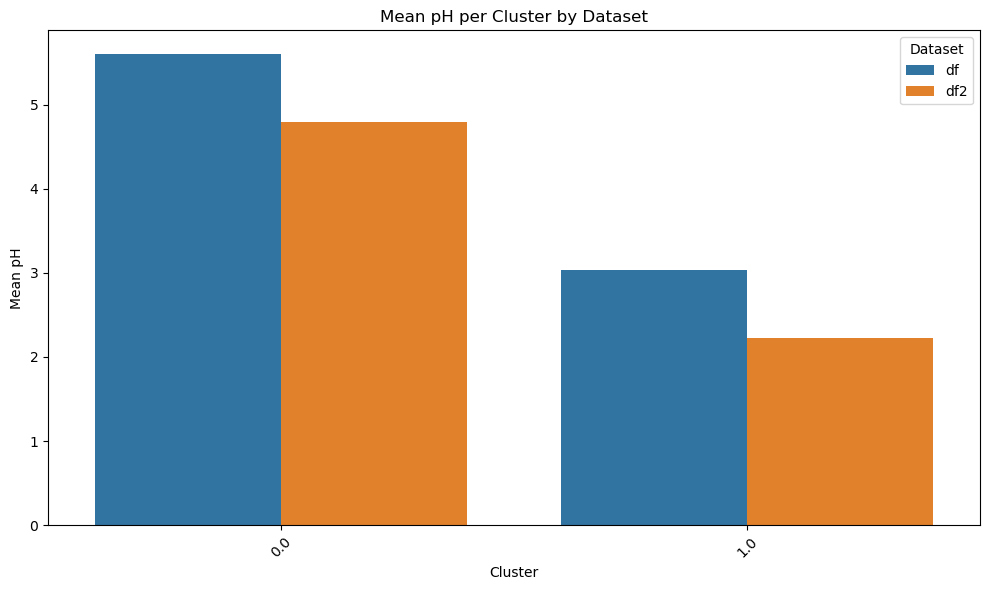

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your dataframes.

# Step 1: Merge df2 with df1 to assign the 'cluster' to df2
df2_merged = pd.merge(df2, df1[['crop', 'crop_predecessor', 'cluster']], on=['crop', 'crop_predecessor'], how='left')

# Step 2: Calculate the mean pH for each cluster in df1 (df already has clusters)
df1_mean_ph = df1.groupby('cluster')['ph'].mean().reset_index()
df1_mean_ph['source'] = 'df'

# Step 3: Calculate the mean pH for each cluster in df2 (after merging clusters)
df2_mean_ph = df2_merged.groupby('cluster')['ph'].mean().reset_index()
df2_mean_ph['source'] = 'df2'

# Step 4: Combine the results from both datasets
combined_df = pd.concat([df1_mean_ph, df2_mean_ph])

# Step 5: Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='ph', hue='source', data=combined_df)

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Mean pH')
plt.title('Mean pH per Cluster by Dataset')
plt.legend(title='Dataset')

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()


In [9]:
fields = pd.DataFrame({
    "field": df_fields["field"],
    "delta" : df_fields["delta"],
    "crop" : df_fields["crop"],
    "season" : df_fields["season"],
    "p2o5" : df_fields["p2o5"],
    "k2o" : df_fields["k2o"],
    "humus" : df_fields["humus"],
    "ph" : df_fields["ph"],
    "yield_fact" : df_fields["yield_fact"]    
})

In [19]:
df_merged = pd.merge(fields_23, fields_24, on=['field'], suffixes=('_2023', '_2024'))

# List of numerical columns to subtract
numerical_columns = ['delta', 'p2o5', 'k2o', 'humus', 'ph']

# Create a new dataframe to hold the differences
df_diff = pd.DataFrame()

# Copy the 'crop' and 'field' columns to the new dataframe
df_diff['field'] = df_merged['field']

# Perform subtraction for each numerical column (2024 - 2023)
for col in numerical_columns:
    df_diff[col + '_diff'] = df_merged[col + '_2024'] - df_merged[col + '_2023']

# Show the resulting dataframe with differences
print(df_diff)


                field  delta_diff  p2o5_diff  k2o_diff  humus_diff  ph_diff
0     22.47.01.001.01         NaN    -237.38     16.23      401.86    -1.32
1     22.47.01.001.02         NaN    -237.38     16.23      401.86    -1.32
2     22.47.01.002.00         NaN    -214.06     15.18      530.52    -1.87
3     22.47.01.003.00         NaN    -199.21     12.87      490.99     0.55
4     22.47.01.004.00         NaN    -177.32     20.57      290.44     0.22
...               ...         ...        ...       ...         ...      ...
5174  36.29.07.028.00   -0.048002     -68.97   -115.50      165.41    -0.99
5175  36.29.07.032.00    0.777780    -146.63   -100.10      116.06    -0.66
5176  36.29.07.036.00    2.174981    -112.53   -141.90       95.93    -0.33
5177  36.29.07.039.00   -2.902523     -74.36    -72.60       94.83    -0.77
5178  36.29.07.045.00   -0.790467    -125.07   -168.30       15.55    -1.21

[5179 rows x 6 columns]


In [21]:
crop = fields_24[["field", "crop", "crop_predecessor"]]

In [23]:
merged_df = pd.merge(crop, df_diff, on='field', how='inner')

In [25]:
df = merged_df

In [27]:
df = df.dropna(subset="delta_diff")

In [29]:
# Group by 'crop' and 'crop_predecessor' and calculate the mean of the numerical features
grouped = df.groupby(['crop', 'crop_predecessor']).agg(
    {'delta_diff': 'mean',
     'p2o5_diff': 'mean',
     'k2o_diff': 'mean',
     'humus_diff': 'mean',
     'ph_diff': 'mean'
     
    }).reset_index()

# Count the occurrences of each combination of 'crop' and 'crop_predecessor'
count_group = df.groupby(['crop', 'crop_predecessor']).size().reset_index(name='count')

# Merge the mean values and the counts back into one dataframe
result = pd.merge(grouped, count_group, on=['crop', 'crop_predecessor'])

# Filter out rows with a count less than 30
result_filtered = result[result['count'] >= 10].drop(columns='count')

# The result_filtered dataframe is your final dataframe
print(result_filtered)

                                               crop  \
4                                             Горох   
12                           Кл.кр.+тим.пр.лет корм   
13                           Кл.кр.+тим.пр.лет корм   
17                                   Кукуруза зерно   
20                                   Кукуруза зерно   
23                                   Кукуруза зерно   
26                                   Кукуруза зерно   
29                                   Кукуруза зерно   
40                                   Кукуруза силос   
44                                   Кукуруза силос   
46                                   Кукуруза силос   
50                                   Кукуруза силос   
51                                   Кукуруза силос   
54                                   Кукуруза силос   
58                                   Кукуруза силос   
59                                   Кукуруза силос   
61                                   Кукуруза силос   
62        

In [31]:
df = result_filtered.dropna(subset="delta_diff")

In [33]:
X = df
X_data = X.drop(['crop', 'crop_predecessor'], axis=1)  # Drop the 'field' column

# Standardize the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Apply KMeans clustering
n_clusters = 2  # Choose the number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the cleaned DataFrame (X)
X['cluster'] = cluster_labels

# Now merge back the cluster labels into the original df_diff (which may have missing values)
df = df.merge(X[['crop', 'crop_predecessor', 'cluster']], on=[['crop', 'crop_predecessor']], how='left')

# Reduce the data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Optionally, you can check the cluster centers in the original feature space:
print("Cluster Centers (in the original scaled space):")
print(kmeans.cluster_centers_)


C:\Users\mp155\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KeyError: ['crop', 'crop_predecessor']

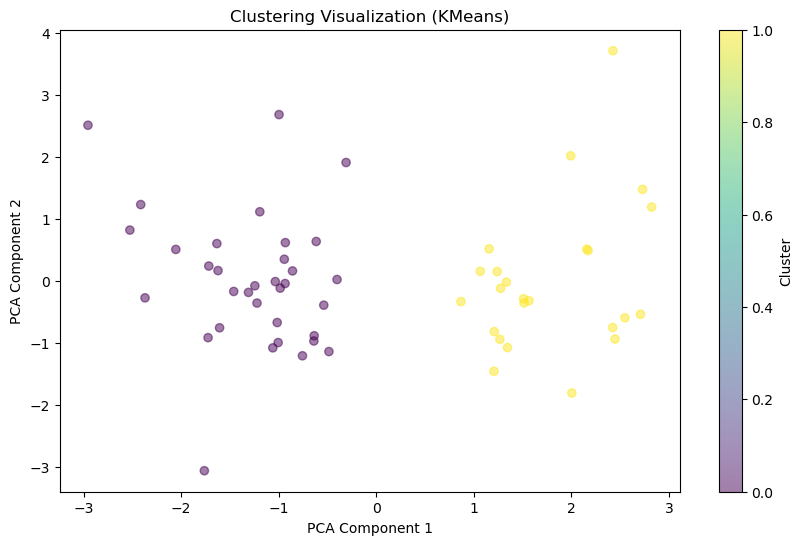

In [35]:
X = df
X_data = X.drop(['crop', 'crop_predecessor'], axis=1)  # Drop the 'field' column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))

# Scatter plot of the PCA components, coloring by 'cluster'
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'], cmap='viridis', alpha=0.5)

# Customize the plot
plt.title('Clustering Visualization (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [39]:
df

,crop,crop_predecessor,delta_diff,p2o5_diff,k2o_diff,humus_diff,ph_diff,cluster
4,Горох,Яр.пшеница мягкая,0.274796,-157.667895,-21.394211,139.637368,-0.144737,0
12,Кл.кр.+тим.пр.лет корм,Одн.тр.(вика+овёс)с подс.(кл.кр.+тим.корм)корм,2.270915,-130.685238,64.271429,40.620952,-1.969524,1
13,Кл.кр.+тим.пр.лет корм,Одн.тр.райграс одн.с подс.(кл.кр.+тим.корм)корм,0.541206,-58.335424,1.862542,39.904407,-2.712712,1
17,Кукуруза зерно,Кукуруза зерно,-2.137508,-87.439000,-22.899000,51.741500,-1.069000,1
20,Кукуруза зерно,Люцерна пр.лет корм,1.403080,-121.155000,-2.375000,78.583636,-0.004545,0
23,Кукуруза зерно,Оз.пшеница мягкая,-2.505815,-87.494167,-9.632917,49.322917,-0.419583,1
26,Кукуруза зерно,Соя,-2.068230,-104.895932,-8.696102,80.925593,-0.782712,1
29,Кукуруза зерно,Яр.пшеница мягкая,-0.979503,-163.797000,3.450000,104.779000,-0.615000,0
40,Кукуруза силос,Кукуруза зерно,-1.653875,-97.792000,-6.829750,97.552000,-0.441250,0
44,Кукуруза силос,Кукуруза силос,-1.423856,-101.834535,1.279070,71.943430,-1.442093,1


In [41]:
df.groupby("cluster").describe()["ph_diff"]

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,34.0,-0.246006,0.691673,-1.484231,-0.585706,-0.333434,0.043864,2.520833
1,24.0,-1.808364,1.032081,-3.592632,-2.673456,-1.655080,-1.040614,-0.042308
